In [2]:
# %pip install netCDF4
# %pip install h5py
# %pip install xarray
# %pip install matplotlib
# %pip install GDAL
%pip install rasterio


   ---------------------------------------- 0.0/30.9 MB ? eta -:--:--
   --- ------------------------------------ 2.9/30.9 MB 16.9 MB/s eta 0:00:02
   --------- ------------------------------ 7.1/30.9 MB 18.7 MB/s eta 0:00:02
   ------------- -------------------------- 10.5/30.9 MB 19.5 MB/s eta 0:00:02
   ------------------ --------------------- 14.7/30.9 MB 18.7 MB/s eta 0:00:01
   ----------------------- ---------------- 18.4/30.9 MB 18.7 MB/s eta 0:00:01
   ---------------------------- ----------- 22.3/30.9 MB 18.7 MB/s eta 0:00:01
   --------------------------------- ------ 26.2/30.9 MB 18.8 MB/s eta 0:00:01
   ------------------------------------ --- 28.0/30.9 MB 17.5 MB/s eta 0:00:01
   ---------------------------------------  30.7/30.9 MB 16.9 MB/s eta 0:00:01
   ---------------------------------------- 30.9/30.9 MB 16.1 MB/s  0:00:01

   ---------------------------------------- 0/5 [click]
   ---------------------------------------- 0/5 [click]
   -------- --------------------

In [3]:
import os
import h5py
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from osgeo import gdal


ModuleNotFoundError: No module named 'osgeo'

In [4]:
input_base_path = os.path.abspath('./Inputs')


In [13]:
def print_h5_structure(file_path):
    with h5py.File(file_path, 'r') as h5file:
        def visitor(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")
            else:
                print(f"Group: {name}")
        h5file.visititems(visitor)

In [14]:
print_h5_structure(os.path.join(input_base_path, 'imd_rainfall_2010_2025.h5'))

Dataset: lat, Shape: (129,), Dtype: float32
Dataset: lon, Shape: (135,), Dtype: float32
Dataset: rainfall, Shape: (5844, 129, 135), Dtype: float32
Dataset: time, Shape: (5844,), Dtype: int32


In [35]:
ds = Dataset(os.path.join(input_base_path, 'RF25_ind2021_rfp25.nc'))
print(ds)                 
print(ds.variables.keys())
var = ds.variables["RAINFALL"]
print(var.shape, var.dtype)

<class 'netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    history: FERRET V7.5 (optimized) 20-Jan-23
    Conventions: CF-1.6
    dimensions(sizes): LONGITUDE(135), LATITUDE(129), TIME(365)
    variables(dimensions): float64 LONGITUDE(LONGITUDE), float64 LATITUDE(LATITUDE), float64 TIME(TIME), float64 RAINFALL(TIME, LATITUDE, LONGITUDE)
    groups: 
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
(365, 129, 135) float64


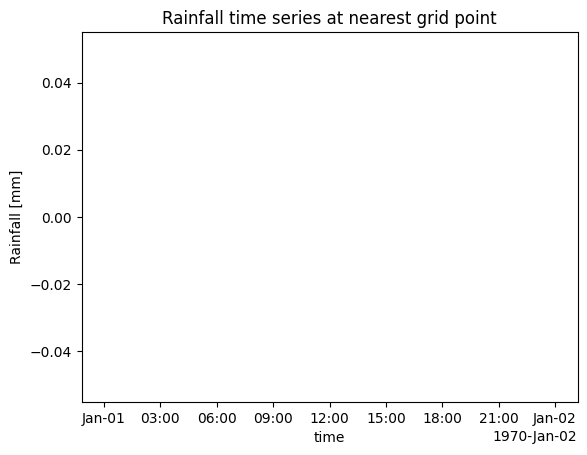

In [5]:
ds = xr.open_dataset(os.path.join(input_base_path, 'RF25_ind2021_rfp25.nc'))
rain = ds["RAINFALL"]

# choose a lat/lon nearest to a point
ts = rain.sel(LATITUDE=30.0, LONGITUDE=70.0, method="nearest")
ts.plot()
plt.title("Rainfall time series at nearest grid point")
plt.show()

In [7]:
ds = Dataset(os.path.join(input_base_path, 'RF25_ind2021_rfp25.nc'))

time_var = ds.variables["TIME"]
print(time_var.units)              # e.g., "days since 1980-01-01"
print(getattr(time_var, "calendar", "standard"))
print(time_var[:5])                # first few values

days since 1900-12-31
standard
[43831. 43832. 43833. 43834. 43835.]


In [9]:
from netCDF4 import Dataset, num2date

ds = Dataset(os.path.join(input_base_path, 'RF25_ind2021_rfp25.nc'))
time = ds.variables["TIME"]
dates = num2date(time[:], units=time.units, calendar=getattr(time, "calendar", "standard"))

print(dates[:5])   # first 5 dates
print(dates[0], dates[-1], len(dates))


[cftime.DatetimeGregorian(2021, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 1, 2, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 1, 3, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 1, 4, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 1, 5, 0, 0, 0, 0, has_year_zero=False)]
2021-01-01 00:00:00 2021-12-31 00:00:00 365


In [ ]:
with open(os.path.join(input_base_path, 'RF25_ind2021_rfp25.nc'), "r") as f:
    for _ in range(20):
        print(f.readline().rstrip())


Checking TIff Files

In [5]:
import rasterio
import os
import numpy as np

In [12]:
input_tiff_path = os.path.abspath('./Inputs/AHRC_tiff_files')
input_tiff_file = "SMAP_L4_SM_gph_20200101T073000_Vv8010_001.tif"
tif_path = os.path.join(input_tiff_path, input_tiff_file)

In [9]:
with rasterio.open(tif_path) as src:
    print("Driver:", src.driver)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Bounds:", src.bounds)
    print("Width, Height:", src.width, src.height)
    print("Count (bands):", src.count)
    print("Dtype:", src.dtypes)
    print("Nodata:", src.nodata)
    print("Descriptions:", src.descriptions)
    print("Tags:", src.tags())

    # Read first band
    band1 = src.read(1, masked=True)
    print("Band1 min/max/mean:", float(band1.min()), float(band1.max()), float(band1.mean()))
    print("Band1 unique sample:", np.unique(band1.compressed())[:20])

Driver: GTiff
CRS: EPSG:4326
Transform: | 0.08, 0.00,-179.95|
| 0.00,-0.08, 84.66|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-179.9533233642578, bottom=-46.88755926513673, right=132.3826766357422, top=84.65644073486328)
Width, Height: 3856 1624
Count (bands): 1
Dtype: ('uint8',)
Nodata: None
Descriptions: (None,)
Tags: {'AREA_OR_POINT': 'Area'}
Band1 min/max/mean: 0.0 255.0 15.650268661979029
Band1 unique sample: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [10]:
with rasterio.open(tif_path) as src:
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Width, Height:", src.width, src.height)
    print("Tags:", src.tags())
    print("Band 1 tags:", src.tags(1))

CRS: EPSG:4326
Transform: | 0.08, 0.00,-179.95|
| 0.00,-0.08, 84.66|
| 0.00, 0.00, 1.00|
Width, Height: 3856 1624
Tags: {'AREA_OR_POINT': 'Area'}
Band 1 tags: {}


In [13]:
with rasterio.open(tif_path) as src:
    print("Descriptions:", src.descriptions)
    print("Tags:", src.tags())
    print("Band 1 tags:", src.tags(1))


Descriptions: (None,)
Tags: {'AREA_OR_POINT': 'Area'}
Band 1 tags: {}
